In [333]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

import torch 
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

import networkx as nx

from holisticai.datasets import load_dataset
from holisticai.bias.metrics import classification_bias_metrics

from utils import evaluate_model

# 1. Data Collection


In [334]:
compas = load_dataset('compas_two_year_recid')
df = compas.data

feature_sets = {
    'X': df['X'].columns.tolist(),  # non-sensitve features
    'S': df['p_attrs'].columns.tolist(),  # sensitive features
    'y': df['y'].columns.tolist()  # target
}

df.columns = df.columns.droplevel(0)

df = df.drop(columns=[
    'days_b_screening_arrest',
    'decile_score',
    'c_days_from_compas',
    'v_decile_score',
    'age_cat_25 - 45',
    'age_cat_Greater than 45',
    'age_cat_Less than 25',
    'score_text_High',
    'score_text_Low',
    'score_text_Medium',
    'v_type_of_assessment_Risk of Violence',
    'v_score_text_High',
    'v_score_text_Low',
    'v_score_text_Medium',
    'c_charge_degree_M',
])

For this experiment, we restrict our analysis on the cohort including African-Americans and Caucasians.


In [335]:
df = df[df['race'].isin(['African-American', 'Caucasian'])]

# Define mappings for known categorical columns
mappings = {
    'race': {'African-American': 0, 'Caucasian': 1},
    'sex': {'Male': 0, 'Female': 1},
    'c_charge_degree': {'F': 0, 'M': 1}  # Example of charge degree mapping
}

# Apply mappings dynamically to relevant columns
for column, mapping in mappings.items():
    if column in df.columns:
        df[column] = df[column].map(mapping)

df = df.rename(columns={'c_charge_degree_F': 'c_charge_degree'})

# Ensure all other columns are numeric
df = df.apply(pd.to_numeric, errors='coerce')

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5278 entries, 1 to 6170
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   priors_count     5278 non-null   int64  
 1   juv_fel_count    5278 non-null   int64  
 2   juv_misd_count   5278 non-null   int64  
 3   juv_other_count  5278 non-null   int64  
 4   c_charge_degree  5278 non-null   float64
 5   y                5278 non-null   int64  
 6   race             5278 non-null   int64  
 7   sex              5278 non-null   int64  
 8   age              5278 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 412.3 KB


In [337]:
df.head()

subfeatures,priors_count,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,y,race,sex,age
1,0,0,0,0,1.0,1,0,0,34
2,4,0,0,1,1.0,1,0,0,24
4,14,0,0,0,1.0,1,1,0,41
6,0,0,0,0,0.0,0,1,1,39
7,0,0,0,0,1.0,0,1,0,27


# 2. Exploratory Data Analysis


In [338]:
# pass

# 3. Define Causal Models


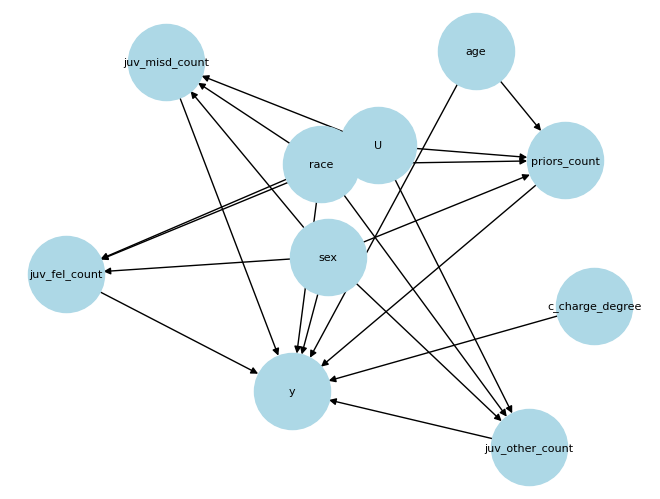

In [339]:
# 1. Define causal graph

edges = [
    ('priors_count', 'y'),
    ('juv_fel_count', 'y'),
    ('juv_misd_count', 'y'),
    ('juv_other_count', 'y'),
    ('c_charge_degree', 'y'),
    ('c_charge_degree', 'y'),
    ('race', 'priors_count'),
    ('race', 'juv_fel_count'),
    ('race', 'juv_misd_count'),
    ('race', 'juv_other_count'),
    ('race', 'y'),
    ('sex', 'priors_count'),
    ('sex', 'juv_fel_count'),
    ('sex', 'juv_misd_count'),
    ('sex', 'juv_other_count'),
    ('sex', 'y'),
    ('age', 'priors_count'),
    ('age', 'y'),
    ('U', 'priors_count'),
    ('U', 'juv_fel_count'),
    ('U', 'juv_misd_count'),
    ('U', 'juv_other_count')
]

causal_graph = nx.DiGraph(edges)

nx.draw(causal_graph, nx.spring_layout(causal_graph, seed=0), with_labels=True, node_size=3000, node_color='lightblue', font_size=8)

Each node corresponds to a variable, and each set of edges into a node corresponds to the generative model between that node and its parents. The relationship can be deterministic (a function) or non-deterministic (a probability distribution), which can be learned using OLS, decision trees, NNs, etc.. Here, we will be using OLS.


In [340]:
# 2. Fit structural equations

df['U'] = np.random.normal(0, 1, df.shape[0])

causal_relationships = {
    'priors_count': ['race', 'sex', 'age', 'U'],
    'juv_fel_count': ['priors_count', 'race', 'sex', 'U'],
    'juv_misd_count': ['race', 'sex', 'U'],
    'juv_other_count': ['race', 'sex', 'U'],
    'y': ['priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
          'c_charge_degree', 'race', 'sex', 'age']
}

structural_equations = {}

for child, parents in causal_relationships.items():
    X = df[parents]
    
    y = df[child]

    # Fit regression model
    model = sm.OLS(y, X).fit()
    structural_equations[child] = model

In [341]:
for var, model in structural_equations.items():
        equation = f'{var} = '
        equation += ' + '.join([f'{coef:.2f}*{name}' for name, coef in model.params.items()])
        print(equation)

priors_count = -2.18*race + -1.16*sex + 0.13*age + 0.05*U
juv_fel_count = 0.02*priors_count + -0.01*race + -0.02*sex + -0.00*U
juv_misd_count = 0.04*race + 0.02*sex + -0.00*U
juv_other_count = 0.10*race + 0.01*sex + -0.01*U
y = 0.03*priors_count + 0.04*juv_fel_count + 0.02*juv_misd_count + 0.13*juv_other_count + 0.22*c_charge_degree + 0.02*race + 0.00*sex + 0.00*age


Given a complete set of equations, we can compute the distribution of any variables had certain other variables been different, while other things being equal. This enables enable counterfactual inference using three steps as outlined by Pearl:

1. **Abduction**: Given the set of observed variables $X = \{X_1, \dots, X_d\}$, compute the values of the set of unobserved variables $U = \{U_1, \dots, U_p\}$ given the model. For non-deterministic models, compute the posterior distribution $P(U \mid X)$.
2. **Action**: Replace all occurrences of the variable $W$ with the value $w$ in the model equations.
3. **Prediction**: Using the new model equations and $U$ (or $P(U \mid X)$), compute the value of $V$ (or $P(V \mid X)$). This final step provides the value or distribution of $V_{W \gets w}$ given the observed, factual variables.


In [342]:
def abduction(df, causal_relationships, structural_equations):
    '''
    Infer a single latent variable U based on residuals across all child nodes
    that depend on U.

    TODO: Not sure if this is right.
    '''
    # Iterate through all child nodes to compute residuals
    total_residuals = 0
    count = 0
    for child, parents in causal_relationships.items():
        if 'U' in parents:
            # Predict values based on observed parents
            X = df[parents]
            X = sm.add_constant(X)
            predicted = structural_equations[child].predict(X)
            
            # Accumulate residuals
            residuals = df[child] - predicted
            total_residuals += np.mean(residuals)

            count += 1
    
    # Infer global U as the mean of residuals across all child nodes
    U = total_residuals / count

    return U


def apply_intervention(df, variable):
    df_intervened = df.copy()
    df_intervened[variable] = df_intervened[variable].apply(lambda x: 1 if x == 0 else (0 if x == 2 else x))

    return df_intervened


def predict_counterfactual(df_intervened, causal_relationships, structural_equations):
    df_cf = df_intervened.copy()

    for child, parents in causal_relationships.items():
        X = df_cf[parents]
        df_cf[child] = structural_equations[child].predict(X)

    return df_cf

In [343]:
# 3. Causal inference (counterfactuals)
df_cf_race = predict_counterfactual(apply_intervention(df, 'race'), causal_relationships, structural_equations)
X_cf_race = df_cf_race.drop(columns=['y'])

df_cf_sex = predict_counterfactual(apply_intervention(df, 'sex'), causal_relationships, structural_equations)
X_cf_sex = df_cf_sex.drop(columns=['y'])

# 4. Model Training


In [344]:
metrics_df = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']})

In [345]:
class Preprocessor:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X):
        # Fit scaler and imputer on the training data
        X = self.scaler.fit_transform(X)
        return X

    def transform(self, X):
        # Apply preprocessing transformations
        X = self.scaler.transform(X)
        return X

    def fit_transform(self, X):
        # Combine fit and transform for training data
        return self.fit(X)


In [346]:
class LogisticRegressionFairness(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.weights = nn.Linear(input_dim, 1)

    def forward(self, X):
        return torch.sigmoid(self.weights(X))
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predict_proba(self, X):
        weights_np = self.weights.weight.detach().numpy()           # Convert weights to NumPy array
        bias_np = self.weights.bias.detach().numpy()                # Convert bias to NumPy array

        linear_model = np.dot(X, weights_np.T) + bias_np

        prob_class_1 = self.sigmoid(linear_model)  # Probability of class 1
        prob_class_0 = 1 - prob_class_1            # Probability of class 0
        
        return np.hstack([prob_class_0, prob_class_1])
    
    def predict(self, X, threshold=0.5):
        weights_np = self.weights.weight.detach().numpy()           # Convert weights to NumPy array
        bias_np = self.weights.bias.detach().numpy()                # Convert bias to NumPy array

        linear_model = np.dot(X, weights_np.T) + bias_np

        prob_class_1 = self.sigmoid(linear_model)  # Probability of class 1
        return (prob_class_1 >= threshold).astype(int)
    


def train_model(X_train, y_train, lr=0.01, epochs=100, preprocessor=None, X_cfs=None, X=None, penalty_weight=0, epsilon=1e-5):
    '''
    Train a logistic regression model with a fairness penalty evaluated on a second dataset.
    '''
    # Preprocess training data
    X_train = torch.tensor(preprocessor.fit_transform(X_train), dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Ensure correct shape

    if X_cfs is not None:
        X = torch.tensor(preprocessor.transform(X), dtype=torch.float32)
        # Preprocess counterfactual datasets
        X_cfs = [torch.tensor(preprocessor.transform(X_cf), dtype=torch.float32) for X_cf in X_cfs]
    
    model = LogisticRegressionFairness(X_train.shape[1])
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Logistic loss on the training data
        y_pred = model(X_train)
        logistic_loss = loss_fn(y_pred, y_train)
        
        # COUNTERFACTUAL FAIRNESS CRITERION
        penalty = 0
        if X_cfs is not None:
            for X_cf in X_cfs:
                penalty += torch.mean(torch.clamp(torch.abs(model(X_cf) - model(X)) - epsilon, min=0))

        # Total loss
        loss = logistic_loss + penalty_weight * penalty

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Penalty: {penalty.item():.4f}')

    return model, preprocessor

In [347]:
# Initial split: df -> df_train and df_test
df_train, df_test = train_test_split(
    df, test_size=0.2, shuffle=True, stratify=df['y'], random_state=0
)

# Second split: df_train -> df_train and df_dev
df_train, df_dev = train_test_split(
    df_train, test_size=0.2, shuffle=True, stratify=df_train['y'], random_state=0
)

# Extract features and targets
y_train = df_train['y']
X_train = df_train.drop(columns=['y'])

y_dev = df_dev['y']
X_dev = df_dev.drop(columns=['y'])

y_test = df_test['y']
X_test = df_test.drop(columns=['y'])


X = df.drop(columns=['y'])
X_cf_race = X_cf_race.reindex(columns=X_train.columns)
X_cf_sex = X_cf_sex.reindex(columns=X_train.columns)

In [348]:
preprocessor = Preprocessor()

cf_model, cf_processor = train_model(X_train, y_train, lr=2, epochs=10000, preprocessor=preprocessor, X_cfs=[X_cf_race, X_cf_sex], X=X, penalty_weight=2, epsilon=0.001)

X_test_scale = cf_processor.transform(X_test.copy())
y_hat = cf_model.predict(X_test_scale)
y_prob = cf_model.predict_proba(X_test_scale)

metrics_df['CF'] = evaluate_model(y_test, y_hat, y_prob).values()

Epoch 10/10000, Loss: 1.1726, Penalty: 0.1855
Epoch 20/10000, Loss: 0.8444, Penalty: 0.0365
Epoch 30/10000, Loss: 0.7863, Penalty: 0.0093
Epoch 40/10000, Loss: 0.7758, Penalty: 0.0042
Epoch 50/10000, Loss: 0.7714, Penalty: 0.0022
Epoch 60/10000, Loss: 0.7698, Penalty: 0.0014
Epoch 70/10000, Loss: 0.7689, Penalty: 0.0010
Epoch 80/10000, Loss: 0.7683, Penalty: 0.0008
Epoch 90/10000, Loss: 0.7679, Penalty: 0.0006
Epoch 100/10000, Loss: 0.7677, Penalty: 0.0005
Epoch 110/10000, Loss: 0.7674, Penalty: 0.0005
Epoch 120/10000, Loss: 0.7673, Penalty: 0.0004
Epoch 130/10000, Loss: 0.7672, Penalty: 0.0004
Epoch 140/10000, Loss: 0.7671, Penalty: 0.0004
Epoch 150/10000, Loss: 0.7670, Penalty: 0.0005
Epoch 160/10000, Loss: 0.7670, Penalty: 0.0005
Epoch 170/10000, Loss: 0.7669, Penalty: 0.0005
Epoch 180/10000, Loss: 0.7669, Penalty: 0.0005
Epoch 190/10000, Loss: 0.7668, Penalty: 0.0006
Epoch 200/10000, Loss: 0.7667, Penalty: 0.0006
Epoch 210/10000, Loss: 0.7667, Penalty: 0.0007
Epoch 220/10000, Loss:

In [349]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count'])
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=None, random_state=0))
])

# Fit the model
full_model = pipeline.fit(X_train, y_train)
y_hat = full_model.predict(X_test)
y_prob = full_model.predict_proba(X_test)

metrics_df['Full'] = evaluate_model(y_test,y_hat, y_prob).values()

In [350]:
X_train.columns

Index(['priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'c_charge_degree', 'race', 'sex', 'age', 'U'],
      dtype='object', name='subfeatures')

In [351]:
blind = ['priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']

blind_model = pipeline.fit(X_train[blind], y_train)
y_hat = blind_model.predict(X_test)
y_prob = blind_model.predict_proba(X_test)

metrics_df['Blind'] = evaluate_model(y_test,y_hat, y_prob).values()

# 5. Model Evaluation


In [352]:
metrics_df

,Metric,CF,Full,Blind
0,Accuracy,0.549281,0.623275,0.623275
1,Precision,0.610811,0.673981,0.673981
2,Recall,0.227364,0.432596,0.432596
3,F1,0.331378,0.526961,0.526961
4,ROC-AUC,0.630747,0.692031,0.692031
